In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# Generative AI competition analysis

The goal of the competition is to create a model that can differientiate between real and fake profile picture photos. However, the data in this competition is not image data but image changed into tabular data for which it is not possible to revert back into pictures. It is therefore a tabular data competition.

## EDA

In [29]:
df = pd.read_feather(r'C:\Users\Jonah\OneDrive\Documents\Thesis\data-science-util\data\cleaned\generative_ai_dataset\train.feather')
df_test = pd.read_feather(r'C:\Users\Jonah\OneDrive\Documents\Thesis\data-science-util\data\cleaned\generative_ai_dataset\test.feather')
df

,labels,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_1190,f_1191,f_1192,f_1193,f_1194,f_1195,f_1196,f_1197,f_1198,f_1199
0,0,-2.033875,0.978446,-0.142131,-0.177117,-1.470684,1.669562,-0.196530,-0.125239,-0.452284,...,-1.111266,0.716084,0.060039,0.301279,-1.174846,-1.076498,-0.069452,-0.604012,-2.179176,0.558003
1,1,-0.348835,0.294815,-0.557577,-2.020773,-1.234715,1.633930,-1.680658,-0.358146,0.166122,...,0.735240,0.829781,1.521941,1.347946,0.754505,1.330642,-0.754453,0.582956,0.252671,1.495870
2,1,0.113248,-0.607726,-0.947791,0.830851,0.998291,0.498321,-1.493958,0.789572,-1.311018,...,0.104698,0.616189,-1.035953,2.111387,-0.984415,1.148076,-1.433554,0.243372,0.170083,1.274795
3,0,1.223321,-0.479048,-1.925789,1.680377,0.021840,-1.453307,0.605559,-0.019024,1.065448,...,0.360237,-1.957863,-0.123384,1.505329,0.660290,-1.769443,-0.547756,-0.568122,0.244645,0.982116
4,0,0.160109,0.422684,-0.308029,0.227744,0.432854,0.608348,0.193832,1.035091,-0.538868,...,0.416629,1.441766,0.212572,-0.994721,1.143999,-2.166923,-1.199248,-1.028636,0.752791,0.317169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,0,1.157565,-0.142219,1.043992,1.144946,1.195423,0.248978,-1.505100,-0.874137,-1.782724,...,1.195423,-0.255793,-0.154838,0.413029,-0.482939,-1.277953,-0.445082,1.195423,-0.924614,-0.432462
5246,0,1.424709,0.235910,1.356778,1.368099,-0.318862,1.039765,-0.986854,-0.330184,-1.383120,...,1.424709,-1.066107,0.881258,-0.488691,-1.281223,-1.213291,0.122692,1.175627,-1.145360,0.451026
5247,1,-0.375687,1.524455,0.012514,-0.007917,0.073809,-0.906909,-1.254247,1.606182,0.298557,...,-0.028349,-0.968204,-1.233815,1.626613,-0.191802,1.115823,0.380284,-0.293960,0.135104,1.381434
5248,1,-0.478238,1.666142,0.049609,-0.428752,-0.362771,1.798104,-0.214314,0.775400,-0.379267,...,-0.428752,-1.121552,-0.379267,-0.593705,0.049609,1.765114,0.313533,-0.329781,-1.220524,0.033114


In [31]:
label= df['labels']
df_feature = df.drop(columns='labels')

We see that there is many feature due to the origin of the data being from images. This is a high dimensionality problem, we can therefore look into dimensionality reduction techniques.

### PCA

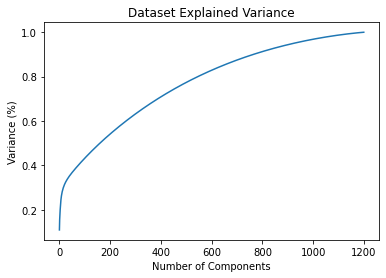

Optimal number of components:  923


In [32]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_feature)

# Perform PCA
pca = PCA()
pca.fit(scaled_features)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Dataset Explained Variance')
plt.show()

# Based on the plot, choose the optimal number of components. 
# An optimal number of components typically explains around 95% of the variance.
optimal_components = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

print('Optimal number of components: ', optimal_components)

# Perform PCA with the optimal number of components
pca = PCA(n_components=optimal_components)
principalComponents = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data = principalComponents)


Here we first look by how much we can reduce the dimensionality using PCA while not loosing too much of the varience, i.e. keeping 95% of the variance

Baseline result using XGBoost:

In [33]:
xgb_model = xgb.XGBClassifier()
# train test split 
X_train, X_test, y_train, y_test = train_test_split(df_feature,label, test_size=0.2)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(f1_score(y_pred,y_test))

0.7013574660633484


Using PCA reduced data we get an improved F1 score.

In [34]:
xgb_model = xgb.XGBClassifier()
# train test split 
X_train, X_test, y_train, y_test = train_test_split(principalDf,label, test_size=0.2)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(f1_score(y_pred,y_test))

0.7121535181236673


### T-SNE

c:\tools\miniconda3\envs\work\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\tools\miniconda3\envs\work\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


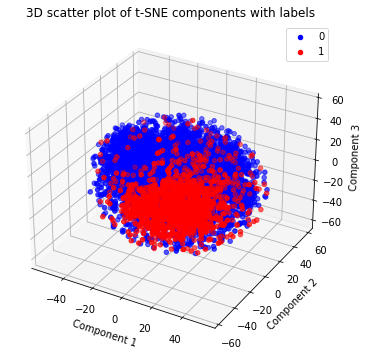

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming that df is your DataFrame and 'labels' is your target column
# df = pd.read_csv('your_file.csv') 

# Separating out the target
target = df['labels']

# Separating out the features
features = df.drop(['labels'], axis=1)

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform t-SNE
tsne = TSNE(n_components=3, random_state=42) # Set to 3 components for 3D visualization
tsne_results = tsne.fit_transform(scaled_features)

# Create a DataFrame with the t-SNE components
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2', 'Component 3'])

# Append the target labels to this dataframe
tsne_df_full = pd.concat([tsne_df, target], axis = 1)

# Visualize the results with labels in 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

categories = np.unique(target)
colors = ['b', 'r']

for i, category in enumerate(categories):
    ax.scatter(tsne_df_full[target==category]['Component 1'], tsne_df_full[target==category]['Component 2'], tsne_df_full[target==category]['Component 3'], c=colors[i], label=str(category))

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('3D scatter plot of t-SNE components with labels')
plt.legend()
plt.show()


In [57]:
xgb_model = xgb.XGBClassifier()
# train test split 
X_train, X_test, y_train, y_test = train_test_split(tsne_df,target, test_size=0.2)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(f1_score(y_pred,y_test))

0.6863905325443788


### Autoencoder latent space

Another technique would be to use the autoencoder latent space reduced dimensions.

In [7]:
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go
df = pd.read_feather(r'C:\Users\Jonah\OneDrive\Documents\Thesis\data-science-util\data\cleaned\generative_ai_dataset\train.feather')
# train test split
#train, test = train_test_split(df, test_size=0.2, random_state=42)
# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that data_tensor is your tensor
# data_tensor = your_tensor 
# Separating out the target
target = df['labels']

# Separating out the features
features = df.drop(['labels'], axis=1)

# Convert the DataFrame to a numpy array and then to a torch tensor
data_tensor = torch.from_numpy(features.values.astype(np.float32))
# Define the autoencoder
class SimpleDropoutAutoencoder(nn.Module):
    def __init__(self, num_features):
        super(SimpleDropoutAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True), 
            nn.Linear(64, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), 
            nn.Linear(256, num_features))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the number of features
num_features = data_tensor.size(1)

# Initialize the autoencoder
dropout_autoencoder = SimpleDropoutAutoencoder(num_features).to(device)





# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dropout_autoencoder.parameters(), lr=0.01)

# Training the autoencoder
num_epochs = 500  # You may need to increase this value depending on your data
for epoch in range(num_epochs):
    inputs = data_tensor.to(device)
    outputs = dropout_autoencoder(inputs)
    loss = criterion(outputs, inputs)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract the latent space
# Extract the latent space
# Extract the latent space
latent_space = dropout_autoencoder.encoder(data_tensor.to(device)).cpu().detach().numpy()

# Convert target to numpy for easy indexing
target_np = target.to_numpy()

# Create a trace for each class (0, 1)
trace0 = go.Scatter3d(
    x = latent_space[target_np==0, 0],
    y = latent_space[target_np==0, 1],
    z = latent_space[target_np==0, 2],
    mode = 'markers',
    name = 'Label 0',
    marker = dict(
        size = 3,
        color = 'blue',
    )
)

trace1 = go.Scatter3d(
    x = latent_space[target_np==1, 0],
    y = latent_space[target_np==1, 1],
    z = latent_space[target_np==1, 2],
    mode = 'markers',
    name = 'Label 1',
    marker = dict(
        size = 3,
        color = 'red',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [14]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Get the encoded features from the autoencoder
encoded_features = dropout_autoencoder.encoder(data_tensor.to(device)).cpu().detach().numpy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_features, target, test_size=0.2, random_state=42)

# Create and train the classifier
clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
clf.fit(X_train, y_train)

# Create and train the classifier
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Compute the F1 score
f1 = f1_score(y_test, y_pred)

print(f"F1 score: {f1:.2f}")

F1 score: 0.69


In this solution we see a distinctiove separation between the two labels in only 3 dimensions! This is very promising. Let's see if we can get even more separation.

### Variational Autoencoder

In [62]:
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

df = pd.read_feather(r'C:\Users\Jonah\OneDrive\Documents\Thesis\data-science-util\data\cleaned\generative_ai_dataset\train.feather')
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that data_tensor is your tensor
# data_tensor = your_tensor 
# Separating out the target
target = train['labels']

# Separating out the features
features = train.drop(['labels'], axis=1)

# Convert the DataFrame to a numpy array and then to a torch tensor
data_tensor = torch.from_numpy(features.values.astype(np.float32))
# Define the autoencoder
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features):
        super(VariationalAutoencoder, self).__init__()
        
        self.fc1 = nn.Linear(num_features, 256)
        self.fc21 = nn.Linear(256, 3)  # Mean of latent variables
        self.fc22 = nn.Linear(256, 3)  # Log variance of latent variables

        self.fc3 = nn.Linear(3, 64)
        self.fc4 = nn.Linear(64, 256)
        self.fc5 = nn.Linear(256, num_features)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, num_features), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD
# Define the number of features
num_features = data_tensor.size(1)

# Initialize the autoencoder
dropout_autoencoder = VariationalAutoencoder(num_features).to(device)





# Loss and optimizer
optimizer = torch.optim.Adam(dropout_autoencoder.parameters(), lr=0.01)

# Training the VAE
num_epochs = 1000  # You may need to increase this value depending on your data
for epoch in range(num_epochs):
    inputs = data_tensor.to(device)
    outputs, mu, logvar = dropout_autoencoder(inputs)
    loss = vae_loss(outputs, inputs, mu, logvar)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Extract the latent space
mu, logvar = dropout_autoencoder.encode(data_tensor.to(device))
latent_space = dropout_autoencoder.reparameterize(mu, logvar).cpu().detach().numpy()


# Convert target to numpy for easy indexing
target_np = target.to_numpy()

# Create a trace for each class (0, 1)
trace0 = go.Scatter3d(
    x = latent_space[target_np==0, 0],
    y = latent_space[target_np==0, 1],
    z = latent_space[target_np==0, 2],
    mode = 'markers',
    name = 'Label 0',
    marker = dict(
        size = 3,
        color = 'blue',
    )
)

trace1 = go.Scatter3d(
    x = latent_space[target_np==1, 0],
    y = latent_space[target_np==1, 1],
    z = latent_space[target_np==1, 2],
    mode = 'markers',
    name = 'Label 1',
    marker = dict(
        size = 3,
        color = 'red',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


We get another significant improvement in score. The reasoning behind using th variational autoencoder is to get an even more distinct separation between the two labels. We can improve our autoencoder with dropouts and early stopping:

In [63]:
# Convert the test set into torch tensors
test_target = test['labels']
test_features = test.drop(['labels'], axis=1)
test_data_tensor = torch.from_numpy(test_features.values.astype(np.float32))

# Create labels for your training set
labels = torch.from_numpy(target.values.astype(np.int64))

# Extract the latent space representations for the training and test sets
with torch.no_grad():
    mu, logvar = dropout_autoencoder.encode(data_tensor.to(device))
    train_latent_space = dropout_autoencoder.reparameterize(mu, logvar).cpu()

    mu, logvar = dropout_autoencoder.encode(test_data_tensor.to(device))
    test_latent_space = dropout_autoencoder.reparameterize(mu, logvar).cpu()

# Define a simple linear classifier
classifier = nn.Linear(3, 2).to(device)  # assuming you have two classes and 3 latent dimensions

# Use Cross Entropy Loss for the classification task
classification_criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer
classification_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

# Train the classifier
num_epochs = 100  # adjust as needed
for epoch in range(num_epochs):
    inputs = train_latent_space.to(device)
    target_labels = labels.to(device)
    outputs = classifier(inputs)
    loss = classification_criterion(outputs, target_labels)
    
    classification_optimizer.zero_grad()
    loss.backward()
    classification_optimizer.step()

# Predict on the test set
with torch.no_grad():
    test_outputs = classifier(test_latent_space.to(device))
    _, predicted = torch.max(test_outputs.data, 1)

# Calculate the f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_target, predicted.cpu().numpy(), average='weighted')

print(f"F1 Score: {f1}")

F1 Score: 0.7781259238135927


In [85]:
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

df = pd.read_feather(r'C:\Users\Jonah\OneDrive\Documents\Thesis\data-science-util\data\cleaned\generative_ai_dataset\train.feather')
train, val = train_test_split(df, test_size=0.2, random_state=42)
# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that data_tensor is your tensor
# data_tensor = your_tensor 
# Separating out the target
target = train['labels']
val_target = val['labels']
# Separating out the features
features = train.drop(['labels'], axis=1)
val_features = val.drop(['labels'], axis=1)
# Convert the DataFrame to a numpy array and then to a torch tensor
data_tensor = torch.from_numpy(features.values.astype(np.float32))

# Assuming you have tensors for validation data and labels
val_data_tensor = torch.from_numpy(val_features.values.astype(np.float32))
val_target_tensor = torch.from_numpy(val_target.values.astype(np.int64))

# Define the autoencoder
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features, dropout_rate=0.5):
        super(VariationalAutoencoder, self).__init__()
        
        self.fc1 = nn.Linear(num_features, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc21 = nn.Linear(256, 3)  # Mean of latent variables
        self.fc22 = nn.Linear(256, 3)  # Log variance of latent variables

        self.fc3 = nn.Linear(3, 64)
        self.fc4 = nn.Linear(64, 256)
        self.fc5 = nn.Linear(256, num_features)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = self.dropout(h1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = self.dropout(h3)
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    
# L1 regularization parameter
lambda_l1 = 0.001

# Modify your vae_loss function to include L1 regularization:
def vae_loss(recon_x, x, mu, logvar, model):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, num_features), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # L1 regularization term
    l1_reg = 0
    for param in model.parameters():
        l1_reg += torch.sum(torch.abs(param))
    
    return BCE + KLD + lambda_l1 * l1_reg

# Define the number of features
num_features = data_tensor.size(1)

# Initialize the autoencoder
vae  = VariationalAutoencoder(num_features).to(device)





# Loss and optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)

# Variables to store the best loss and the best model state
best_loss = float('inf')
best_model_state = vae.state_dict()

# Define your stopping criteria
n_epochs_stop = 10  # If the validation loss hasn't improved in 10 epochs, stop training
epochs_no_improve = 0
# Training the VAE
num_epochs = 1000  # You may need to increase this value depending on your data
for epoch in range(num_epochs):
    inputs = data_tensor.to(device)
    outputs, mu, logvar = vae(inputs)
    loss = vae_loss(outputs, inputs, mu, logvar, vae )
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # After training for an epoch, evaluate on the validation set
    vae.eval()
    with torch.no_grad():
        val_inputs = val_data_tensor.to(device)
        val_outputs, mu, logvar = vae(val_inputs)
        val_loss = vae_loss(val_outputs, val_inputs, mu, logvar, vae).item()

    # If the validation loss is the best we've seen so far, save the model state
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = vae.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        # Check if we should stop training
        if epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            break
        
# Load the best model state
vae.load_state_dict(best_model_state)

# Extract the latent space
mu, logvar = vae.encode(data_tensor.to(device))
latent_space = vae.reparameterize(mu, logvar).cpu().detach().numpy()


# Convert target to numpy for easy indexing
target_np = target.to_numpy()

# Create a trace for each class (0, 1)
trace0 = go.Scatter3d(
    x = latent_space[target_np==0, 0],
    y = latent_space[target_np==0, 1],
    z = latent_space[target_np==0, 2],
    mode = 'markers',
    name = 'Label 0',
    marker = dict(
        size = 3,
        color = 'blue',
    )
)

trace1 = go.Scatter3d(
    x = latent_space[target_np==1, 0],
    y = latent_space[target_np==1, 1],
    z = latent_space[target_np==1, 2],
    mode = 'markers',
    name = 'Label 1',
    marker = dict(
        size = 3,
        color = 'red',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

Early stopping!


In [96]:
# Convert the test set into torch tensors
test_target = test['labels']
test_features = test.drop(['labels'], axis=1)
test_data_tensor = torch.from_numpy(test_features.values.astype(np.float32))

# Create labels for your training set
labels = torch.from_numpy(target.values.astype(np.int64))

# Extract the latent space representations for the training and test sets
with torch.no_grad():
    mu, logvar = vae.encode(data_tensor.to(device))
    train_latent_space = vae.reparameterize(mu, logvar).cpu()

    mu, logvar = vae.encode(test_data_tensor.to(device))
    test_latent_space = vae.reparameterize(mu, logvar).cpu()

# Define a simple linear classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# assuming you have two classes and 3 latent dimensions
classifier = Classifier(3, 16, 2).to(device)
# Use Cross Entropy Loss for the classification task
classification_criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer
classification_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

# Train the classifier
num_epochs = 500  # adjust as needed
for epoch in range(num_epochs):
    inputs = train_latent_space.to(device)
    target_labels = labels.to(device)
    outputs = classifier(inputs)
    loss = classification_criterion(outputs, target_labels)
    
    classification_optimizer.zero_grad()
    loss.backward()
    classification_optimizer.step()

# Predict on the test set
with torch.no_grad():
    test_outputs = classifier(test_latent_space.to(device))
    _, predicted = torch.max(test_outputs.data, 1)

# Calculate the f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_target, predicted.cpu().numpy(), average='weighted')

print(f"F1 Score: {f1}")

F1 Score: 0.8203539460391248


In [90]:

# Convert the test set into torch tensors
test_data_tensor = torch.from_numpy(df_test.values.astype(np.float32))

# Create labels for your training set
labels = torch.from_numpy(target.values.astype(np.int64))

# Extract the latent space representations for the training and test sets
with torch.no_grad():
    mu, logvar = vae.encode(data_tensor.to(device))
    train_latent_space = vae.reparameterize(mu, logvar).cpu()

    mu, logvar = vae.encode(test_data_tensor.to(device))
    test_latent_space = vae.reparameterize(mu, logvar).cpu()
# Predict on the test set
with torch.no_grad():
    test_outputs = classifier(test_latent_space.to(device))
    _, predicted = torch.max(test_outputs.data, 1)

In [80]:
predicted_np = predicted.cpu().numpy()
df = pd.DataFrame({'id': df_test.index, 'labels': predicted_np})
df.to_csv('predictions.csv', index=False)

